# Libs

In [219]:
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import logging
import numpy as np

import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np

import geopandas as gpd
from shapely import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points
from sklearn.cluster import DBSCAN

from tqdm import tqdm
tqdm.pandas()

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm, rc

# 한글 폰트 설정
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 과제: 고객 이탈 분석 및 예측
- 목표:
    - 고객 이탈(Churn)을 예측하고, 이탈을 줄이기 위한 인사이트를 도출합니다.
- 핵심 스킬:
    - 데이터 전처리 및 탐색적 데이터 분석(EDA)
    - 머신러닝 모델링(예: 분류 문제)
    - 데이터 시각화를 통해 결과 해석 및 인사이트 전달
    - 비즈니스 관점에서의 해결책 제안


- Q. 차세대 데이터 분석가가 연습해볼만한 과제와 데이터를 하나 던져줘 (→ GPT)
    - A. 차세대 데이터 분석가로서 연습할 만한 과제는 머신러닝, 데이터 시각화, 비즈니스 인사이트 도출의 세 가지를 모두 아우르는 프로젝트가 좋습니다. (← GPT)

# Data Import

In [220]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /home/bmw/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


# Data Explore

In [221]:
df = pd.read_csv(os.path.join(path,os.listdir(path)[0]))

In [222]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 데이터 구조
- 인구통계 정보
- 가입 및 서비스 정보

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 결측치 확인

In [224]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [225]:
df.describe(include='O')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [226]:
df.describe(exclude='O')

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [227]:
df['Churn'].value_counts(normalize=True)*100

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

## Target
- ```Churn == 'yes'``` means Customer who left within the last month

In [228]:
hi_df = df[df['Churn'] == 'No']
bye_df = df[df['Churn'] == 'Yes']

In [229]:
df.columns[1:-1]

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [230]:
for num,i in enumerate(df['TotalCharges']):
    try:
        float(i)
    except ValueError as e :
        print(f'row number : {num} {e}: {i}')

row number : 488 could not convert string to float: '':  
row number : 753 could not convert string to float: '':  
row number : 936 could not convert string to float: '':  
row number : 1082 could not convert string to float: '':  
row number : 1340 could not convert string to float: '':  
row number : 3331 could not convert string to float: '':  
row number : 3826 could not convert string to float: '':  
row number : 4380 could not convert string to float: '':  
row number : 5218 could not convert string to float: '':  
row number : 6670 could not convert string to float: '':  
row number : 6754 could not convert string to float: '':  


In [231]:
df.loc[df['TotalCharges'].str.contains(' '), 'TotalCharges'] = 0
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(bool)

In [232]:
for i in df.columns[1:-1]:
    if i == 'SeniorCitizen':
        display(f'churn == "no" of {i}', hi_df[i].value_counts(normalize=True)*100)
        display(f'churn == "Yes" of {i}', bye_df[i].value_counts(normalize=True)*100)
    elif df[i].dtype == 'O':
        display(f'churn == "no" of {i}', hi_df[i].value_counts(normalize=True)*100)
        display(f'churn == "Yes" of {i}', bye_df[i].value_counts(normalize=True)*100)
    else :
        display(f'churn == "no" of {i}', hi_df[i].describe())
        display(f'churn == "Yes" of {i}', bye_df[i].describe())
    print('\n')

'churn == "no" of gender'

gender
Male      50.734441
Female    49.265559
Name: proportion, dtype: float64

'churn == "Yes" of gender'

gender
Female    50.24077
Male      49.75923
Name: proportion, dtype: float64

'churn == "no" of SeniorCitizen'

SeniorCitizen
0    87.127947
1    12.872053
Name: proportion, dtype: float64

'churn == "Yes" of SeniorCitizen'

SeniorCitizen
0    74.531835
1    25.468165
Name: proportion, dtype: float64

'churn == "no" of Partner'

Partner
Yes    52.821801
No     47.178199
Name: proportion, dtype: float64

'churn == "Yes" of Partner'

Partner
No     64.205457
Yes    35.794543
Name: proportion, dtype: float64

'churn == "no" of Dependents'

Dependents
No     65.519907
Yes    34.480093
Name: proportion, dtype: float64

'churn == "Yes" of Dependents'

Dependents
No     82.557517
Yes    17.442483
Name: proportion, dtype: float64

'churn == "no" of tenure'

count    5174.000000
mean       37.569965
std        24.113777
min         0.000000
25%        15.000000
50%        38.000000
75%        61.000000
max        72.000000
Name: tenure, dtype: float64

'churn == "Yes" of tenure'

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: tenure, dtype: float64

'churn == "no" of PhoneService'

PhoneService
Yes    90.104368
No      9.895632
Name: proportion, dtype: float64

'churn == "Yes" of PhoneService'

PhoneService
Yes    90.904227
No      9.095773
Name: proportion, dtype: float64

'churn == "no" of MultipleLines'

MultipleLines
No                  49.110939
Yes                 40.993429
No phone service     9.895632
Name: proportion, dtype: float64

'churn == "Yes" of MultipleLines'

MultipleLines
Yes                 45.478866
No                  45.425361
No phone service     9.095773
Name: proportion, dtype: float64

'churn == "no" of InternetService'

InternetService
DSL            37.920371
Fiber optic    34.770004
No             27.309625
Name: proportion, dtype: float64

'churn == "Yes" of InternetService'

InternetService
Fiber optic    69.395399
DSL            24.558587
No              6.046014
Name: proportion, dtype: float64

'churn == "no" of OnlineSecurity'

OnlineSecurity
No                     39.369927
Yes                    33.320448
No internet service    27.309625
Name: proportion, dtype: float64

'churn == "Yes" of OnlineSecurity'

OnlineSecurity
No                     78.170144
Yes                    15.783842
No internet service     6.046014
Name: proportion, dtype: float64

'churn == "no" of OnlineBackup'

OnlineBackup
Yes                    36.838036
No                     35.852339
No internet service    27.309625
Name: proportion, dtype: float64

'churn == "Yes" of OnlineBackup'

OnlineBackup
No                     65.971108
Yes                    27.982879
No internet service     6.046014
Name: proportion, dtype: float64

'churn == "no" of DeviceProtection'

DeviceProtection
No                     36.412833
Yes                    36.277542
No internet service    27.309625
Name: proportion, dtype: float64

'churn == "Yes" of DeviceProtection'

DeviceProtection
No                     64.794007
Yes                    29.159979
No internet service     6.046014
Name: proportion, dtype: float64

'churn == "no" of TechSupport'

TechSupport
No                     39.176652
Yes                    33.513722
No internet service    27.309625
Name: proportion, dtype: float64

'churn == "Yes" of TechSupport'

TechSupport
No                     77.367576
Yes                    16.586410
No internet service     6.046014
Name: proportion, dtype: float64

'churn == "no" of StreamingTV'

StreamingTV
Yes                    36.586780
No                     36.103595
No internet service    27.309625
Name: proportion, dtype: float64

'churn == "Yes" of StreamingTV'

StreamingTV
No                     50.401284
Yes                    43.552702
No internet service     6.046014
Name: proportion, dtype: float64

'churn == "no" of StreamingMovies'

StreamingMovies
Yes                    36.992656
No                     35.697719
No internet service    27.309625
Name: proportion, dtype: float64

'churn == "Yes" of StreamingMovies'

StreamingMovies
No                     50.187266
Yes                    43.766720
No internet service     6.046014
Name: proportion, dtype: float64

'churn == "no" of Contract'

Contract
Month-to-month    42.906842
Two year          31.832238
One year          25.260920
Name: proportion, dtype: float64

'churn == "Yes" of Contract'

Contract
Month-to-month    88.550027
One year           8.881755
Two year           2.568218
Name: proportion, dtype: float64

'churn == "no" of PaperlessBilling'

PaperlessBilling
Yes    53.556243
No     46.443757
Name: proportion, dtype: float64

'churn == "Yes" of PaperlessBilling'

PaperlessBilling
Yes    74.906367
No     25.093633
Name: proportion, dtype: float64

'churn == "no" of PaymentMethod'

PaymentMethod
Mailed check                 25.202938
Electronic check             25.009664
Credit card (automatic)      24.932354
Bank transfer (automatic)    24.855044
Name: proportion, dtype: float64

'churn == "Yes" of PaymentMethod'

PaymentMethod
Electronic check             57.303371
Mailed check                 16.479401
Bank transfer (automatic)    13.804173
Credit card (automatic)      12.413055
Name: proportion, dtype: float64

'churn == "no" of MonthlyCharges'

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

'churn == "Yes" of MonthlyCharges'

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

'churn == "no" of TotalCharges'

count     5174
unique    4966
top           
freq        11
Name: TotalCharges, dtype: object

'churn == "Yes" of TotalCharges'

count     1869
unique    1732
top       20.2
freq         6
Name: TotalCharges, dtype: object

## 가입해지 여부와 변수 분포

- 연관없음
    - gender
    - seniorcitizen
    - PhoneService
    - MultipleLines
- 연관 살짝 보임
    - partner(가입 해지한 경우 파트너가 없는 비율이 더 높음)
    - dependents (가입 해지한 경우 부양가족이 없는 경우가 더 많음)
    - StreamingTV(가입 해지한 고객들의 스트리밍TV 서비스 가입이 적음)
    - StreamingMovies(가입 해지한 고객들의 스트리밍 영화 서비스 가입이 적음)
- 연관있음
    - tenuer(가입 유지율과 가입기간은 높은 연관성이 있음)
    - InternetService (인터넷 서비스 제공자 분포가 차이있음)
    - OnlineSecurity (가입 해지한 고객들은 온라인 보안서비스를 사용하지 않음)
    - OnlineBackup(가입 해지한 고객들은 온라인 백업을 사용하지 않음)
    - DeviceProtection(가입 해지한 고객들은 기기보호를 사용하지 않음)
    - TechSupport(가입 해지한 고객들은 기술지원을 받지 않음)
    - Contract(가입 해지한 고객들은 월단위 구독을 하는 경우가 많음)
    - PaperlessBilling(가입 해지한 고객들은 무용지 청구서를 발행하는 경우가 많음)
    - PaymentMethod(가입 해지한 고객들은 전자수표 사용하는 경우가 압도적임)
    - MonthlyCharges(가입 해지한 고객들의 평균 금액이 더 높음)

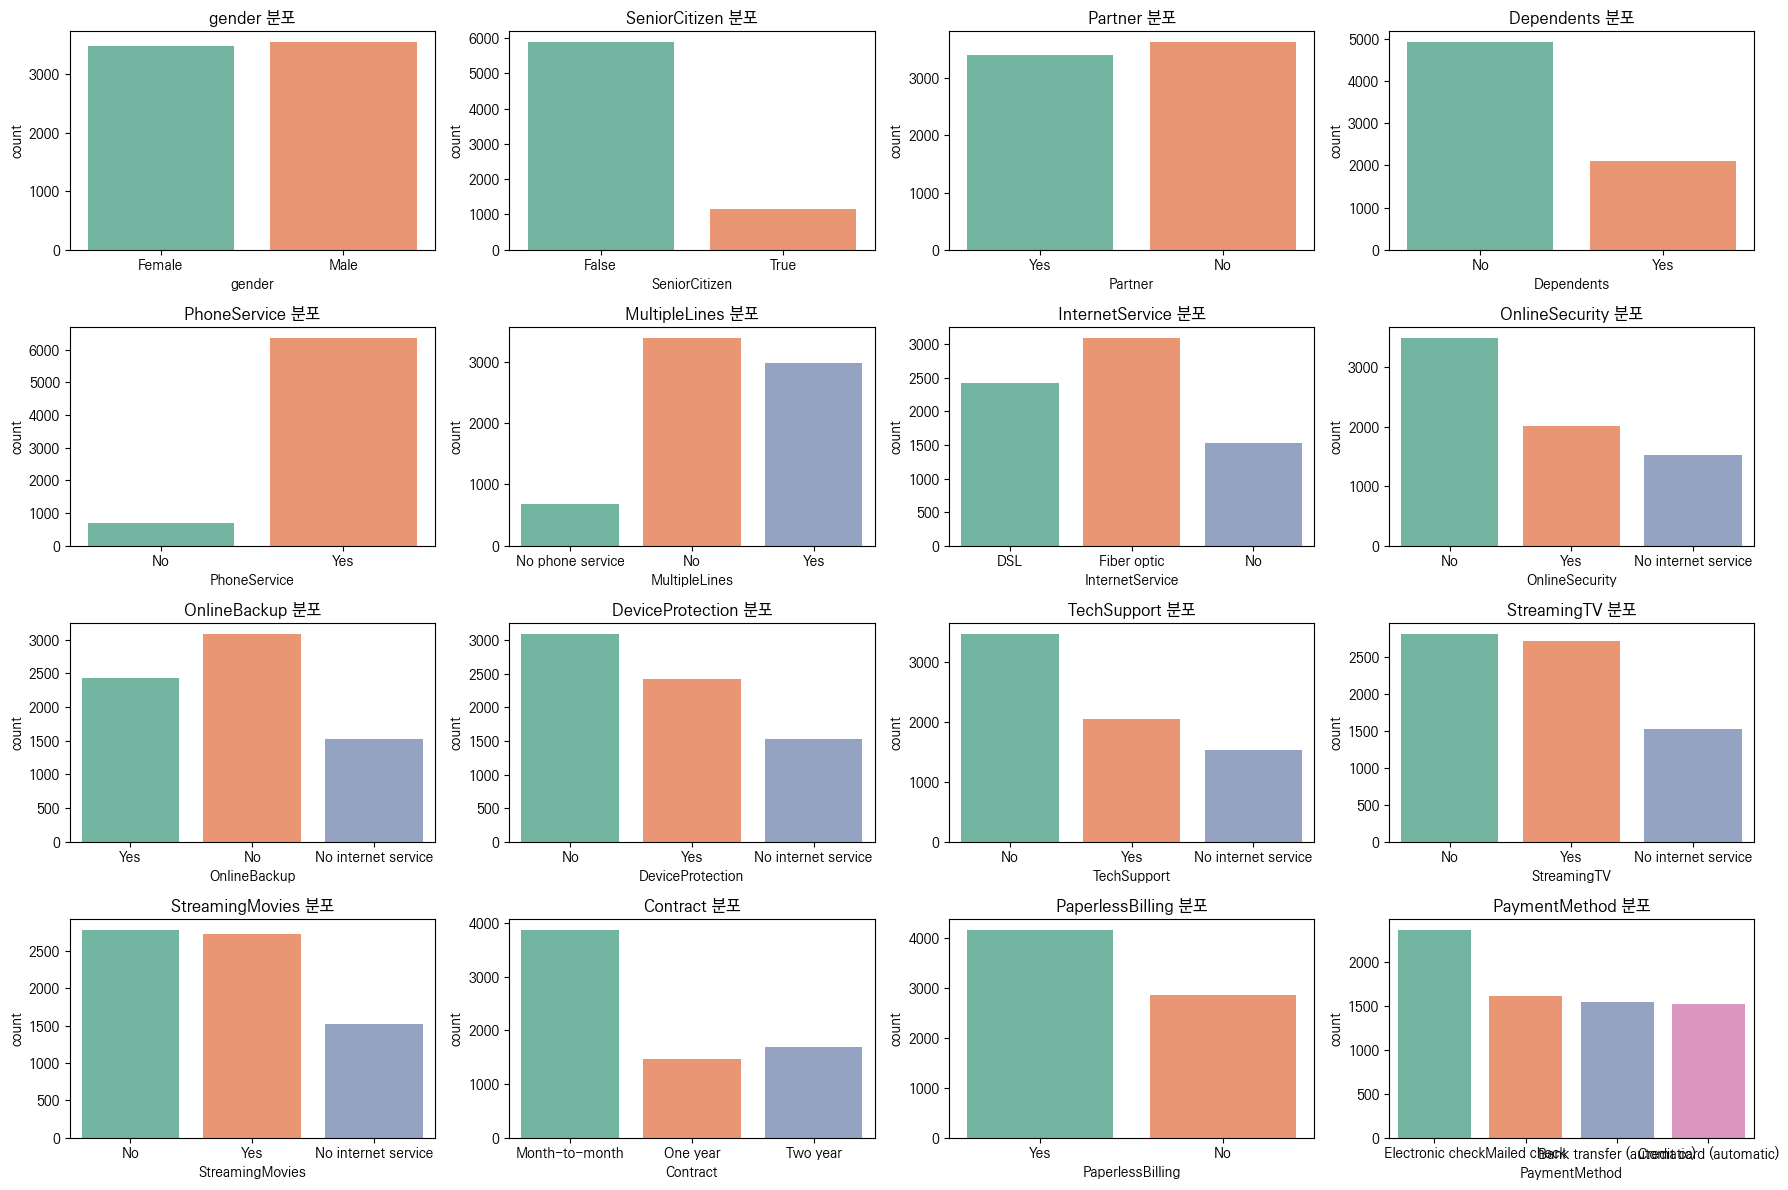

In [ ]:
# 주요 범주형 변수 분포 시각화
fig, axes = plt.subplots(4, 4, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(df.select_dtypes(exclude='number').columns[1:-1]):
    unique_vals = df[col].nunique()
    palette = sns.color_palette("Set2", unique_vals)
    sns.countplot(x=col, data=df, ax=axes[i],palette=palette)
    axes[i].set_title(f'{col} 분포')
plt.tight_layout()
plt.show()

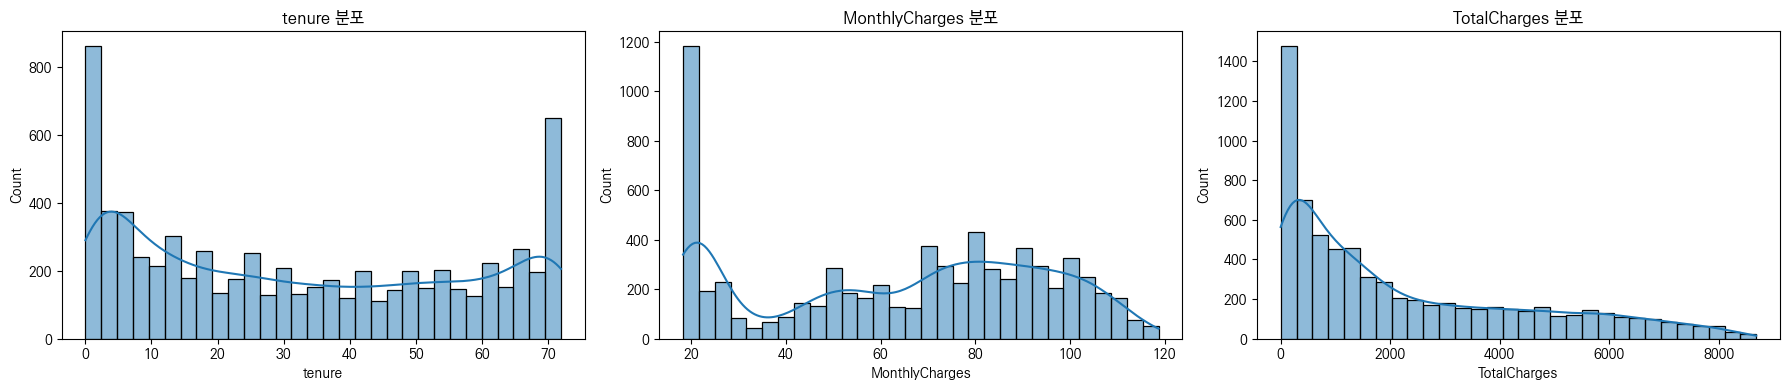

In [49]:
# 주요 수치형 변수 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, col in enumerate(df.select_dtypes(include='number')):
    unique_vals = df[col].nunique()
    palette = sns.color_palette("Set2", unique_vals)
    sns.histplot(df[col], kde=True, ax=axes[i], palette=palette, bins=30)
    axes[i].set_title(f'{col} 분포')
plt.tight_layout()
plt.show()

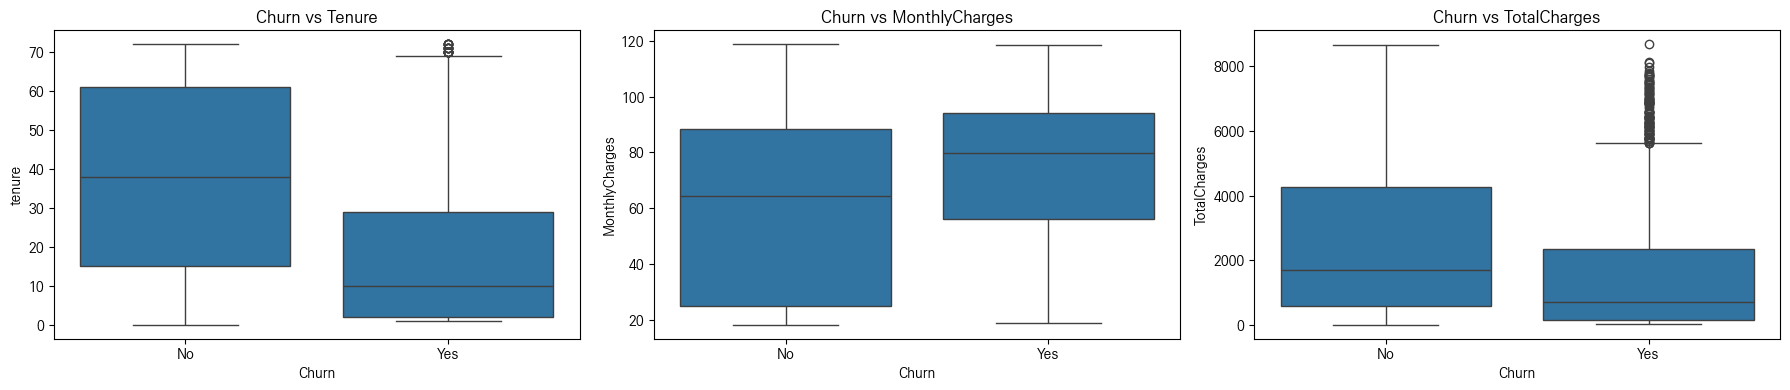

In [39]:
# 타겟(Churn)과 주요 변수의 관계 시각화 예시
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0])
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1])
sns.boxplot(x='Churn', y='TotalCharges', data=df, ax=axes[2])
axes[0].set_title('Churn vs Tenure')
axes[1].set_title('Churn vs MonthlyCharges')
axes[2].set_title('Churn vs TotalCharges')
plt.tight_layout()
plt.show()

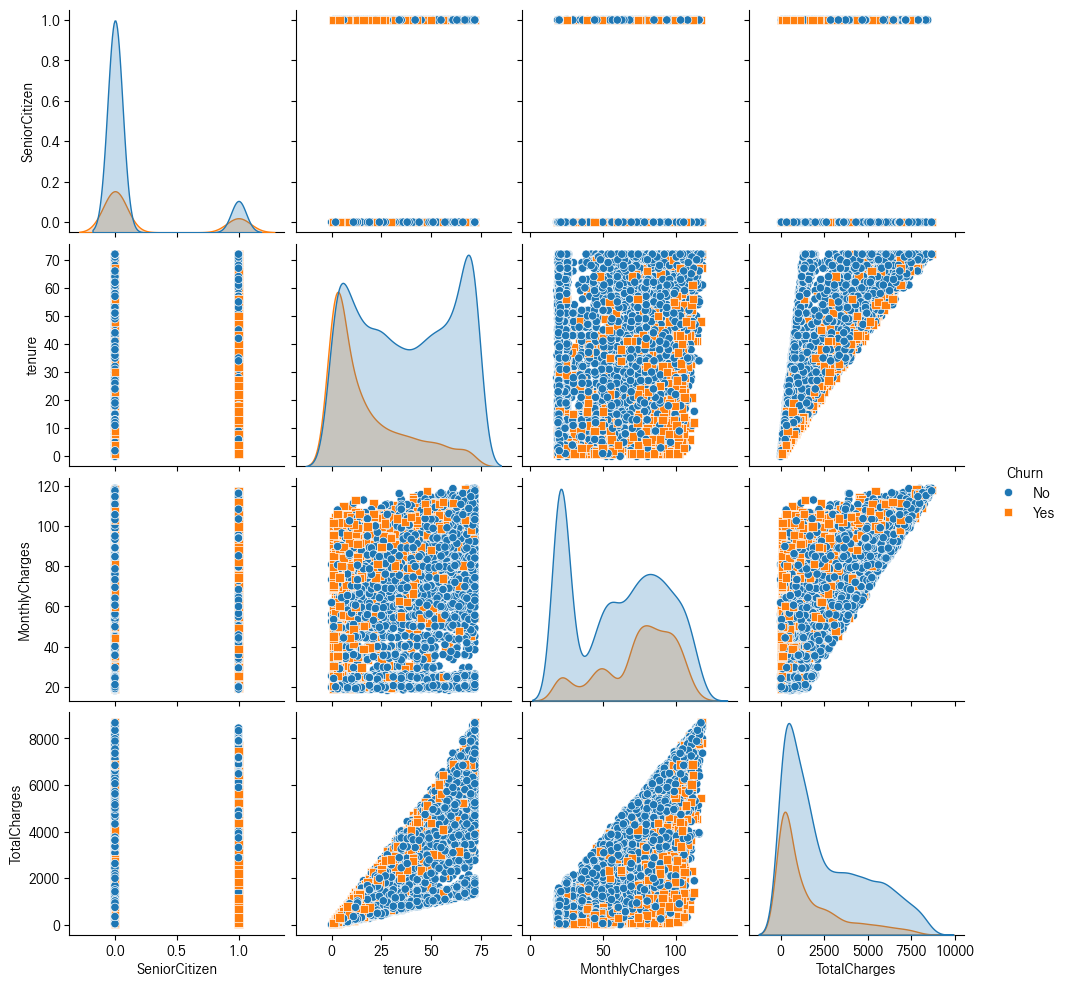

In [34]:
sns.pairplot(df, hue='Churn', diag_kind='kde', markers=["o", "s"], height=2.5)

## Additional EDA

## correlation

In [40]:
df.select_dtypes(include='number').corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.247900,0.826178
MonthlyCharges,0.247900,1.000000,0.651174
TotalCharges,0.826178,0.651174,1.000000


## crosstab

In [52]:
for i in df.select_dtypes(exclude='number').columns[1:-1]:
    display((pd.crosstab(df[i], df['Churn'], normalize=True) * 100).round(2))

Churn,No,Yes
gender,,
Female,36.19,13.33
Male,37.27,13.20


Churn,No,Yes
SeniorCitizen,,
False,64.01,19.78
True,9.46,6.76


Churn,No,Yes
Partner,,
No,34.66,17.04
Yes,38.80,9.50


Churn,No,Yes
Dependents,,
No,48.13,21.91
Yes,25.33,4.63


Churn,No,Yes
PhoneService,,
No,7.27,2.41
Yes,66.19,24.12


Churn,No,Yes
MultipleLines,,
No,36.08,12.05
No phone service,7.27,2.41
Yes,30.12,12.07


Churn,No,Yes
InternetService,,
DSL,27.86,6.52
Fiber optic,25.54,18.42
No,20.06,1.60


Churn,No,Yes
OnlineSecurity,,
No,28.92,20.74
No internet service,20.06,1.60
Yes,24.48,4.19


Churn,No,Yes
OnlineBackup,,
No,26.34,17.51
No internet service,20.06,1.60
Yes,27.06,7.43


Churn,No,Yes
DeviceProtection,,
No,26.75,17.19
No internet service,20.06,1.60
Yes,26.65,7.74


Churn,No,Yes
TechSupport,,
No,28.78,20.53
No internet service,20.06,1.60
Yes,24.62,4.40


Churn,No,Yes
StreamingTV,,
No,26.52,13.37
No internet service,20.06,1.60
Yes,26.88,11.56


Churn,No,Yes
StreamingMovies,,
No,26.22,13.32
No internet service,20.06,1.60
Yes,27.18,11.61


Churn,No,Yes
Contract,,
Month-to-month,31.52,23.50
One year,18.56,2.36
Two year,23.38,0.68


Churn,No,Yes
PaperlessBilling,,
No,34.12,6.66
Yes,39.34,19.88


Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),18.26,3.66
Credit card (automatic),18.32,3.29
Electronic check,18.37,15.21
Mailed check,18.51,4.37


- 전체적으로 서비스와 같이 통신사 서비스를 잘 이용하는 고객이 이탈하지 않을 가능성이 높다
- 더불어 인구통계학적 변수는 고객의 이탈률과는 관계가 없는 듯 하다
 - 굳이 따지자면 청년 1인 가구 정도가 이탈률이 높을 것 같은 느낌

In [55]:
df[df.columns[1:-1]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   bool   
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


<Axes: xlabel='Partner'>

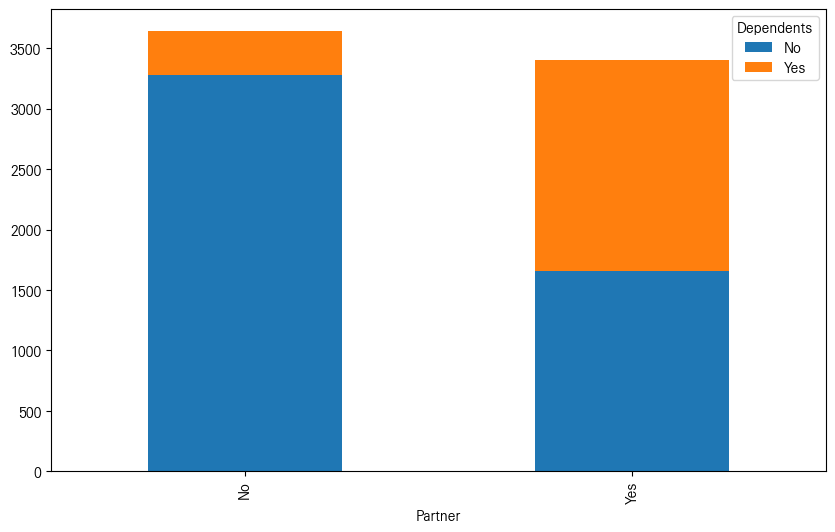

In [58]:
df.groupby(['Partner', 'Dependents']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))